# VISION PIPELINE FOR FINDING LANE LINES IN VIDEOS

# Import Packages

In [1]:
#importing packages for pipeline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
from datapath import data_path_img
from datapath import data_path_video
import math
from scipy import stats
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Import Filenames and Setup Image Paths

In [2]:
# the image_path function accepts the filename
# of an image as an argument and returns the
# file location of the image. 
def img_file_path(img_file_name):
    # set path of image 
    img_file_path = os.path.join(data_path_img, img_file_name)
    # print path of image
    print (img_file_path)
    return img_file_path

# the video_path function accepts the filename
# of an video as an argument and returns the
# file location of the video. 
def video_file_path(video_file_name):
    # set path of image 
    video_file_path = os.path.join(data_path_video, video_file_name)
    # print path of image
    print (video_file_path)
    return video_file_path

# read image
def imread(image):    
    # read image
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    # convert image from BGR to RGB colorspace
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display image
    plt.imshow(RGB_img)
    # save image
    #cv2.imwrite("test_images_output/RGB_img.jpg", img)
    return RGB_img

# the purpose of the grayscale function is
# to accept the path of an image as an argument
# and return the image as grayscale 
def gray_image(image):    
    # convert image from RGB to Gray scale intensity
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # display image
    plt.imshow(gray, cmap="gray")
    # save image
    #cv2.imwrite("test_images_output/grayscale.jpg", gray)
    return gray

# the purpose of the grayscale function is
# to accept the path of an image as an argument
# and return the image as grayscale 
def gray_video(video_file):    
    # read video
    gray = cv2.imread(video_file, 0)
    return gray

# this canny edge detector function accepts a grayscale
# image and a threshold range as arguments and returns sharp edges
# by calculating the gradient magnitude within a threshold.
# The result of the edge detection are many pixels represented
# as lines of edges
def canny(gray, low_threshold, high_threshold):
    # local variables to hold the filter size and smoothed out image
    kernel_size = 3
    blur_Gray_images = []
    # apply image enhancement using a gaussian low-pass filter
    blurred_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0) 
    # apply canny edge detection to all images
    edges = cv2.Canny(blurred_gray, low_threshold, high_threshold)
    # display image
    plt.imshow(edges, cmap="gray")
    # save image
    #cv2.imwrite("test_images_output/edges_detected.jpg", edges)
    return edges

# this region of interest function accepts edges detected 
# in an image and returns a region of pixels defined by
# vertices. the pixels outside of the region are set to black.
def region_of_interest(edges, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(edges)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(edges.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(edges, mask)
    # display image
    plt.imshow(masked_image, cmap="gray")
    # save image
    #cv2.imwrite("test_images_output/masked_image.jpg", masked_image)
    return masked_image

# this hough transform feature extraction function
# accepts pixel-based segmented canny edges detected
# in an image and returns a drawing of lines on an image.
def hough_lines(masked_image):
    # find points that form a line
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    # drawing lines on the RGB images
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image_copy, (x1, y1), (x2, y2), color, thickness)
    # display image
    plt.imshow(image_copy)
    # save image
    #cv2.imwrite("test_images_output/hough_lines_img.jpg", image_copy)
    return image_copy

# Mapping the Full Extent of Detected Lane Lines
# calculate the slopes of segmented left and right
# lane lines. since image row grows left and image
# columns grows down, the left lane line should have
# negative slopes and the right lane line should be
# positive slopes.
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    
    # separate segmented lines as left and right in saggital plan
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_slope = (y2-y1)/(x2-x1)
            if line_slope < 0 and x1 < img_sagittal_plane and x1 < img_sagittal_plane:
                left_lane_lines_x.append(x1)
                left_lane_lines_x.append(x2)
                left_lane_lines_y.append(y1)
                left_lane_lines_y.append(y2)
            elif line_slope > 0 and x1 > img_sagittal_plane and x1 > img_sagittal_plane:
                right_lane_lines_x.append(x1)
                right_lane_lines_x.append(x2)
                right_lane_lines_y.append(y1)
                right_lane_lines_y.append(y2)
        
    # find parameters (slope, intercept) of linear regression equation for lane lines
    
    left_slope, left_intercept, left_r_value, left_p_value, left_std_err = stats.linregress(left_lane_lines_x, left_lane_lines_y)   
    right_slope, right_intercept, right_r_value, right_p_value, right_std_err = stats.linregress(right_lane_lines_x, right_lane_lines_y)

    # using slope-intercept equation of the lines to
    # extrapolate to lines to an estimated end point 
    # from the sagittal plane.
    
    left_lane_x = ((imshape[0] - 1) - left_intercept) / left_slope
    right_lane_x = ((imshape[0] - 1) - right_intercept) / right_slope
    
    # drawing lines on the RGB images
    detected_lane = cv2.line(image_full, (int(left_lane_x), int(imshape[0] - 1)), (int(v2[0]), int(v2[1])), (255, 0, 0), 3)
    detected_lane = cv2.line(image_full, (int(right_lane_x), int(imshape[0] - 1)), (int(v3[0]), int(v3[1])), (255, 0, 0), 3)
    
    # weighted image
    detected_lane = cv2.addWeighted(image_full, α, detected_lane, β, γ)
    
    # display image
    plt.imshow(detected_lane) 
    # save image
    #cv2.imwrite("test_images_output/wt_hough_lines.jpg", detected_lane)
    return detected_lane

## Import Filenames, Setup Image Paths, and Read Images

C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_images/solidWhiteRight.jpg


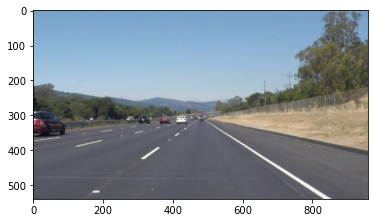

In [51]:
# global variables to hold filename and path
img_file_name = os.listdir("test_images/")
image = img_file_path('solidWhiteRight.jpg')
img = imread(image)

## Read Images to Grayscale

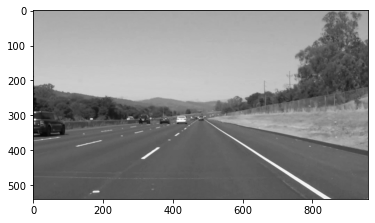

In [52]:
gray = gray_image(img)

#  Canny Edge Detection

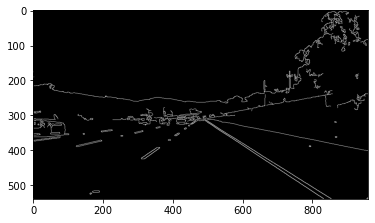

In [53]:
edges = canny(gray, 25, 200)

# Region of Interest to Create Masked Images

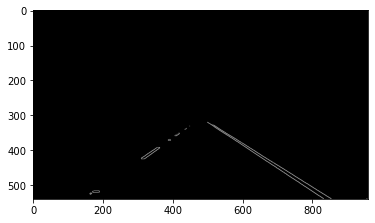

In [54]:
# global variables to hold the location of vertices
imshape = img.shape
imshape = edges.shape

# global variables to hold vertix points increasing along x-axis
v1 = (120, imshape[0])
v2 = (450, 330)
v3 = (500, 320)
v4 = (imshape[1],imshape[0])

vertices = np.array([[v1 ,v2, v3, v4]], dtype=np.int32)

segmented_image = region_of_interest(edges, vertices)

# Hough Transform Feature Extraction

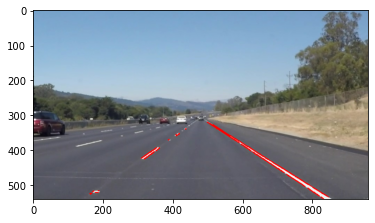

In [55]:
# global variables to hold hough transform parameters
rho = 2
theta = np.pi/180
threshold = 20
min_line_length = 1
max_line_gap = 1

# global variables for overlaying lines on an image
image_copy = np.copy(img)
color = [255, 0, 0]
thickness = 2

hough_line_img = hough_lines(segmented_image)

# Map the Full Extent of Detected Lane Lines

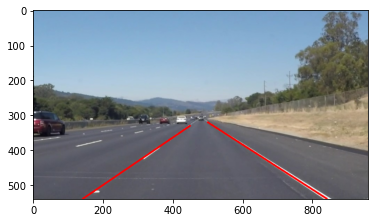

In [56]:
# global variables to hold left and right lane lines
left_lane_lines_x = []
left_lane_lines_y = []
right_lane_lines_x = []
right_lane_lines_y = []

# copy original image
image_full = np.copy(img)

# sagittal plane is at the middle of image
img_sagittal_plane = imshape[1] /2

# global variables for holding math symbols
α = 0.7
β = 0.3
γ = 0.0

# find points that form a line
lines = cv2.HoughLinesP(segmented_image, rho, theta, threshold, min_line_length, max_line_gap)

detected_lanes = draw_lines(image, lines)

In [3]:
# global variables to hold left and right lane lines
left_lane_lines_x = []
left_lane_lines_y = []
right_lane_lines_x = []
right_lane_lines_y = []

def process_image(video_file):
    gray = gray_image(video_file)
    edges = canny(gray, 25, 200)
    
    # local variables to hold the location of vertices
    imshape = edges.shape
    
    # sagittal plane is at the middle of image
    img_sagittal_plane = imshape[1] /2


    # local variables to hold vertix points increasing along x-axis
    v1 = (120, imshape[0])
    v2 = (450, 330)
    v3 = (500, 320)
    v4 = (imshape[1],imshape[0])
    vertices = np.array([[v1 ,v2, v3, v4]], dtype=np.int32)
    
    segmented_image = region_of_interest(edges, vertices)
    
    # global variables to hold hough transform parameters
    rho = 5
    theta = np.pi/180
    threshold = 100
    min_line_length = 10
    max_line_gap = 10
   
    # find points that form a line
    lines = cv2.HoughLinesP(segmented_image, rho, theta, threshold, min_line_length, max_line_gap)
    # drawing lines on the RGB images
    for line in lines:
        for x1,y1,x2,y2 in line:
            detected_lane = cv2.line(video_file, (x1, y1), (x2, y2), (0, 255, 0), 2)

    
    # separate segmented lines as left and right in saggital plan
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_slope = (y2-y1)/(x2-x1)
            if line_slope < 0 and x1 < img_sagittal_plane and x1 < img_sagittal_plane:
                left_lane_lines_x.append(x1)
                left_lane_lines_x.append(x2)
                left_lane_lines_y.append(y1)
                left_lane_lines_y.append(y2)
            elif line_slope > 0 and x1 > img_sagittal_plane and x1 > img_sagittal_plane:
                right_lane_lines_x.append(x1)
                right_lane_lines_x.append(x2)
                right_lane_lines_y.append(y1)
                right_lane_lines_y.append(y2)
        
    # find parameters (slope, intercept) of linear regression equation for lane lines
    left_slope, left_intercept, left_r_value, left_p_value, left_std_err = stats.linregress(left_lane_lines_x, left_lane_lines_y)   
    right_slope, right_intercept, right_r_value, right_p_value, right_std_err = stats.linregress(right_lane_lines_x, right_lane_lines_y)

    # using slope-intercept equation of the lines to
    # extrapolate to lines to an estimated end point 
    # from the sagittal plane.
    left_lane_x = ((imshape[0] - 1) - left_intercept) / left_slope
    right_lane_x = ((imshape[0] - 1) - right_intercept) / right_slope
    
    # drawing lines on the RGB images
    detected_lane = cv2.line(video_file, (int(left_lane_x), int(imshape[0] - 1)), (int(v2[0]), int(v2[1])), (255, 0, 0), 3)
    detected_lane = cv2.line(video_file, (int(right_lane_x), int(imshape[0] - 1)), (int(v3[0]), int(v3[1])), (255, 0, 0), 3)
    
    # global variables for holding math symbols
    α = 0.7
    β = 0.3
    γ = 0.0
    
    # weighted image
    detected_lane = cv2.addWeighted(video_file, α, detected_lane, β, γ)
    return detected_lane

t:   2%|█▌                                                                   | 5/221 [00:00<00:04, 49.02it/s, now=None]

Moviepy - Building video C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4
Wall time: 5.39 s


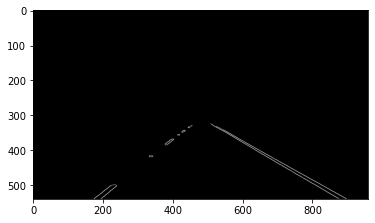

In [4]:
white_output = 'C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("C:/Users/Civiltronics/udacity/projects/CarND-LaneLines-P1/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

t:   1%|▍                                                                    | 4/681 [00:00<00:17, 39.60it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 28.7 s


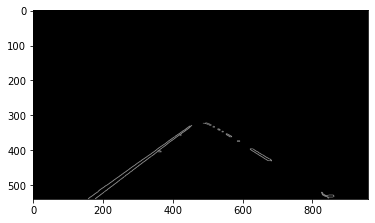

In [6]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

t:   1%|▊                                                                    | 3/251 [00:00<00:09, 25.64it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 19.8 s


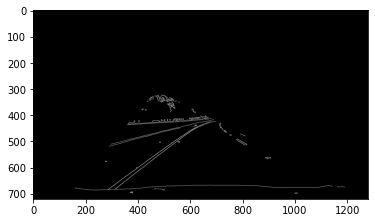

In [8]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))